In [2]:
# limit the number of threads used by xgboost models
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["VECLIB_MAXIMUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"

# standard libaries
import sys
import copy
import dill
from collections import defaultdict
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import random

from sklearn.preprocessing import LabelEncoder

# flow specific packages
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from src.flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from src.flow import ParallelCreditFlow, GraphExplainer, translator
from src.flow import group_nodes, build_feature_graph
from src.flow import CausalLinks, create_xgboost_f
from src.flow import edge_credits2edge_credit, node_dict2str_dict
from src.on_manifold import OnManifoldExplainer, IndExplainer

np.random.seed(42) # fix for reproducibility

In [45]:
# WANTED_COLUMNS = ['VEGA-TENSAOBOBINADEIRA','VEGA-TCM_CVC__CAD3','VEGA-LARGURA_y','LTQ-F1 wear','LTQ-Finishing entry temperature (maximum)','VEGA-ESPESSURA','VEGA-TCM_ABERTURA_CAD_3','VEGA-TCM_EMULSAO_PRESSAO_CAD_2','LTQ-CW target width (hot value)','LTQ-F5-Rolled slab count on this backup roll (lower)','VEGA-CPL_VEL_CIRC_ACIDO_2P1','VEGA-CPL_TQ_SAIDA_1_TEMP','LTQ-Shim Plate (F1) (Top)','LTQ-Head cut type','LTQ-Obligatory RM descale spray code (3rd pass)','VEGA-LARGURAMEDIDACAMERA','LTQ-ISC flow (F4-F5) (head)','VEGA-POSTRATVELROLOSUPERIORPRESET','VEGA-CPL_QTE_OLEAMENTO_INFERIOR','LTQ-Trust Plate (F2) (Top)','VEGA-TCM_ESPESSURA_CAD_3','LTQ-Coefficient of polynomial of left side optimum curve','LTQ-Coefficient of polynomial of right','VEGA-FORNOFLUXODEHNX','VEGA-TORRETEMPMM1']
# LABEL_COLUMN_NAME = 'VEGA-TMFL'

WANTED_COLUMNS = ['partido', 'tema2', 'tema1', 'dis_num_seguiu', 'doacoes_donation_value', 'keyw_alteracao', 'dis_votos_validos', 'keyw_criacao']
LABEL_COLUMN_NAME = 'voto'

# df = pd.read_csv('dados.csv')
df = pd.read_parquet('df_final_label.parquet')

# df[LABEL_COLUMN_NAME] = df[LABEL_COLUMN_NAME].map({'não':0, 'sim':1})
# df.dropna(axis=0, subset=[LABEL_COLUMN_NAME], inplace=True)

categorical_features=["tema1","tema2","partido","doacoes_main_donation"]
encoder = LabelEncoder()
original = df[categorical_features]
mask = df[categorical_features].isnull()
df[categorical_features] = df[categorical_features].fillna('NaN')
df[categorical_features] = df[categorical_features].apply(encoder.fit_transform)
df[categorical_features].where(~mask, original)
df[categorical_features].astype('category')

X = df[WANTED_COLUMNS].fillna(0).values
y = df[LABEL_COLUMN_NAME].values

X_display = df[WANTED_COLUMNS]
y_display = df[LABEL_COLUMN_NAME]

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train, feature_names=WANTED_COLUMNS)
xgb_test = xgboost.DMatrix(X_test, label=y_test, feature_names=WANTED_COLUMNS)

print(X.shape)
X_display.head()

(308002, 8)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao
0,27,19,7,0.0,NaN,0.0,0.0,0.0
1,27,19,7,0.0,NaN,0.0,0.0,0.0
2,27,0,1,0.0,NaN,1.0,0.0,0.0
3,27,19,13,0.0,NaN,0.0,0.0,0.0
4,27,0,1,0.0,NaN,0.0,0.0,0.0


In [48]:
n_bg = 1 # number of sampled background samples
nsamples = 20 # number of fg samples to explain
nruns = 10 # paper: 10,000, number of monte carlo samplings
bg = X_display.fillna(X.mean()).sample(n_bg)
fg = X_display[:nsamples] # foreground samples to explain
sample_ind = 3 # sample to show

In [49]:
fg

,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao
0,27,19,7,0.0,NaN,0.0,0.0,0.0
1,27,19,7,0.0,NaN,0.0,0.0,0.0
2,27,0,1,0.0,NaN,1.0,0.0,0.0
3,27,19,13,0.0,NaN,0.0,0.0,0.0
4,27,0,1,0.0,NaN,0.0,0.0,0.0
5,27,0,1,0.0,NaN,0.0,0.0,0.0
6,27,0,12,0.0,NaN,1.0,0.0,0.0
7,27,0,12,0.0,NaN,1.0,0.0,0.0
8,27,0,12,0.0,NaN,1.0,0.0,0.0
9,27,0,12,0.0,NaN,1.0,0.0,0.0


In [50]:
params = {
    "eta": 0.01,
    "max_depth": 4,
    'objective':'binary:logistic', # output probability
    "subsample": 0.9
}
model = xgboost.train(params, xgb_train, 5000, evals = [(xgb_test, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun


[0]	test-error:0.16675
[1000]	test-error:0.14190
[2000]	test-error:0.13396
[3000]	test-error:0.12922
[4000]	test-error:0.12746
[4999]	test-error:0.12618


0it [00:00, ?it/s]


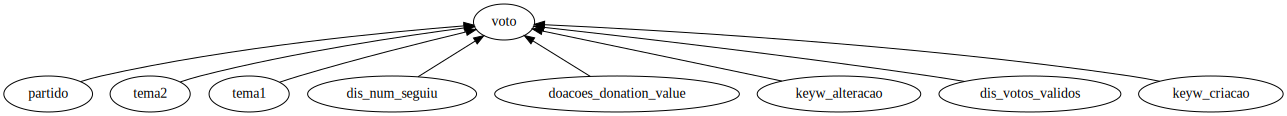

In [41]:
causal_links = CausalLinks()
categorical_feature_names = categorical_features
display_translator = translator(X_display.columns, X, X_display)
feature_names = list(X_display.columns)

# build causal links
causal_links.add_causes_effects(feature_names, LABEL_COLUMN_NAME, create_xgboost_f(feature_names, model))
graph = build_feature_graph(X_display, causal_links, categorical_feature_names, display_translator, LABEL_COLUMN_NAME)
graph.draw()

In [51]:
# multiple background result
edge_credits = [] # save for each run
for i in range(len(bg)): # average run result using linearity axiom
    print(f'bg {i}/{len(bg)}')
    explainer = GraphExplainer(graph, bg[i:i+1], nruns=nruns) 
    display(fg)
    cf = explainer.shap_values(fg)
    edge_credits.append(node_dict2str_dict(cf.edge_credit)) # use node name is more portable vs. node

bg 0/1


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao
0,27,19,7,0.0,NaN,0.0,0.0,0.0
1,27,19,7,0.0,NaN,0.0,0.0,0.0
2,27,0,1,0.0,NaN,1.0,0.0,0.0
3,27,19,13,0.0,NaN,0.0,0.0,0.0
4,27,0,1,0.0,NaN,0.0,0.0,0.0
5,27,0,1,0.0,NaN,0.0,0.0,0.0
6,27,0,12,0.0,NaN,1.0,0.0,0.0
7,27,0,12,0.0,NaN,1.0,0.0,0.0
8,27,0,12,0.0,NaN,1.0,0.0,0.0
9,27,0,12,0.0,NaN,1.0,0.0,0.0


bruteforce sampling:  50%|█████     | 5/10 [00:00<00:00, 42.39it/s]

passou assert
passou bg fg
passou baseline
passou target
set noise sampler
passou bg fg values
começou a iterar
node args > 0
[array([35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35.,
       35., 35., 35., 35., 35., 35., 35.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17.]), array([29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
       29., 29., 29., 29., 29., 29., 29.]), array([45666.66666667, 45666.66666667, 45666.66666667, 45666.66666667,
       45666.66666667, 45666.66666667, 45666.66666667, 45666.66666667,
       45666.66666667, 45666.66666667, 45666.66666667, 45666.66666667,
       45666.66666667, 45666.66666667, 45666.66666667, 45666.66666667,
       45666.66666667, 45666.66666667, 45666.66666667, 45666.66666667]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

bruteforce sampling: 100%|██████████| 10/10 [00:00<00:00, 44.76it/s]


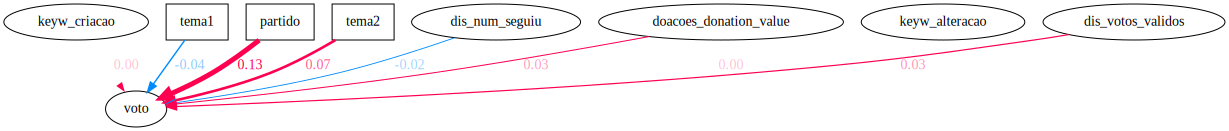

<AGraph <Swig Object of type 'Agraph_t *' at 0x7ff6bd5c5930>>

In [52]:
cf.draw(sample_ind, max_display=10, edge_credit=edge_credits2edge_credit(edge_credits, cf.graph), show_fg_val=False)

In [53]:
feature_names = X_display.columns
f = lambda x: model.predict(xgboost.DMatrix(pd.DataFrame(x, columns=feature_names))) # wrapper for the model used by on manifold explainer

# multiple background result
manifold_edge_credits = [] # save for each run
bg_on_manifold = X_display.fillna(X.mean()).sample(100) # used to learn conditional dependence
for i in range(len(bg)): # average run result using linearity axiom 
    print(f'bg {i}/{len(bg)}')
    explainer = OnManifoldExplainer(f, pd.concat([bg[i:i+1], bg_on_manifold]), nruns=nruns)
    cf_on_manifold = explainer.shap_values(fg)
    manifold_edge_credits.append(cf_on_manifold) # use node name is more portable vs. node

manifold bg samples:   0%|          | 0/20 [00:00<?, ?it/s]

bg 0/1


manifold bg samples: 100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


In [56]:
# print('On manifold')
# sum(manifold_edge_credits).draw(sample_ind, show=False, max_display=30)
# plt.tight_layout()
# plt.show()

learning dependency for dis_votos_validos: 100%|██████████| 4/4 [00:00<00:00, 57.87it/s]


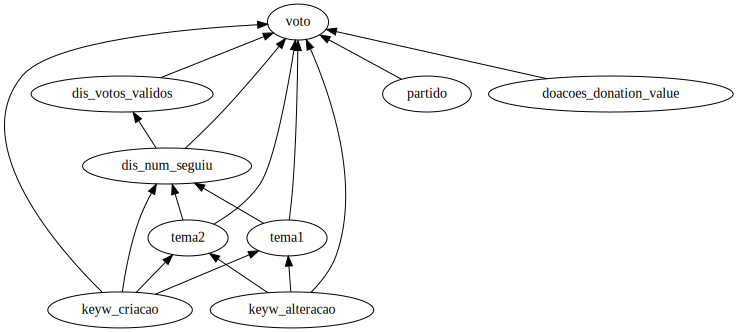

In [58]:
causal_links = CausalLinks()
categorical_feature_names = categorical_features
display_translator = translator(X_display.columns, X, X_display)
feature_names = list(X_display.columns)

# build causal links
causal_links.add_causes_effects(feature_names, LABEL_COLUMN_NAME, create_xgboost_f(feature_names, model)) # target is probability
causal_links.add_causes_effects(['keyw_criacao'],['tema1','tema2','dis_num_seguiu'])
causal_links.add_causes_effects(['keyw_alteracao'],['tema1','tema2'])
causal_links.add_causes_effects(['tema1'],['dis_num_seguiu'])
causal_links.add_causes_effects(['tema2'],['dis_num_seguiu'])
causal_links.add_causes_effects(['dis_num_seguiu'],['dis_votos_validos'])


causal_graph = build_feature_graph(X_display.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, LABEL_COLUMN_NAME, method='linear')
causal_graph.draw()

In [59]:
# multiple background result
causal_edge_credits = [] # save for each run
for i in range(len(bg)): # average run result using linearity axiom
    print(f'bg {i}/{len(bg)}')
    cf_c = GraphExplainer(causal_graph, bg[i:i+1], nruns=nruns).shap_values(fg)
    causal_edge_credits.append(node_dict2str_dict(cf_c.edge_credit)) # use node name is more portable vs. node

bruteforce sampling:  20%|██        | 2/10 [00:00<00:00, 16.25it/s]

bg 0/1
passou assert
passou bg fg
passou baseline
passou target
set noise sampler
passou bg fg values
começou a iterar
node args > 0
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])]
<function create_linear_f.<locals>.f_ at 0x7ff6600de670>
bg_computed
fg_computed
node name in bg values
bg sampled shape != bg computed shape or bg sampled != bg computed
noise node
not noise node
node add arg
entrou no else
numerical variables
node f = node f num
bg diff
baseline sampler
target sampler
node args > 0
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])]
<function create_linear_f.<locals>.f_ at 0x7ff66009f8b0>
bg_computed
fg_computed
node name in bg values
bg sampled shape != bg computed shape or bg sampled != bg 

bruteforce sampling: 100%|██████████| 10/10 [00:00<00:00, 16.42it/s]


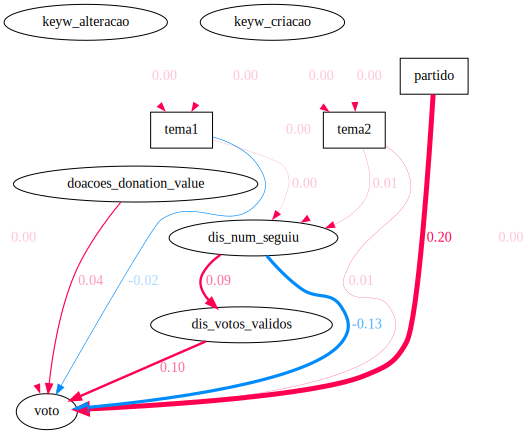

<AGraph <Swig Object of type 'Agraph_t *' at 0x7ff69f02d960>>

In [60]:
cf_c.draw(sample_ind, max_display=25, show_fg_val=False, edge_credit=edge_credits2edge_credit(causal_edge_credits, cf_c.graph))

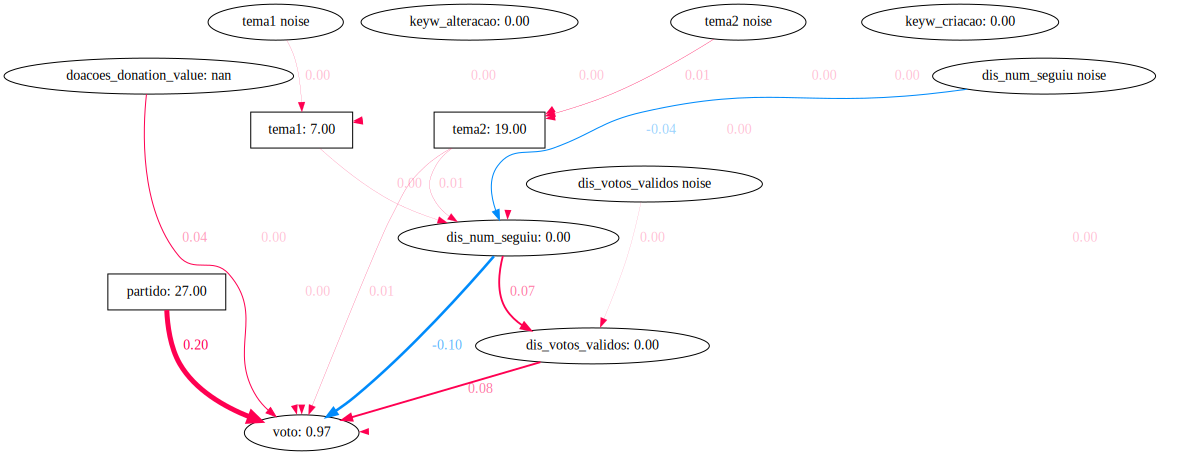

<AGraph <Swig Object of type 'Agraph_t *' at 0x7ff69f0222a0>>

In [68]:
sample_ind = 1
cf_c.fold_noise=False
cf_c.draw(sample_ind, max_display=30)